In [26]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Data

In [27]:
import os

# Define our example directories and files
# Define the initial path

initial_path = '/kaggle/input/breastcancer/Data'

# Define the new top-level directory names
directories = ['train', 'val', 'test']

# Define the subdirectory names for each top-level directory
subdirectories = ['Cancer','Negative']

# Define the proportions for train, validation, and test sets
props = [0.9, 0.05, 0.05]

# Loop over the top-level directories and subdirectories, and create the corresponding directories
for directory in directories:
    for subdirectory in subdirectories:
        path = os.path.join(initial_path, subdirectory)
        files = os.listdir(path)
        random.shuffle(files)
        total = len(files)
        train_end = int(total * props[0])
        val_end = train_end + int(total * props[1])
        if directory == 'train':
            new_files = files[:train_end]
        elif directory == 'val':
            new_files = files[train_end:val_end]
        else:
            new_files = files[val_end:]
        new_path = os.path.join(directory, subdirectory)
        os.makedirs(new_path, exist_ok=True)
        for file in new_files:
            old_file_path = os.path.join(path, file)
            new_file_path = os.path.join(new_path, file)
            shutil.copy(old_file_path, new_file_path)


# Prepare the dataset

In [28]:
# Define the directories for the train, validation, and test sets
train_dir = 'train'
val_dir = 'val'
test_dir = "test"



# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( val_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 818 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


# Bulid Model - Transfer Learning 



In [29]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-04-19 20:35:09--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   180MB/s    in 0.5s    

2023-04-19 20:35:10 (180 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [30]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers


# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
#Copy InceptionV3 to pre_trained_model with changes
pre_trained_model  = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers,because they have been trained already.
for layer in pre_trained_model.layers:
  layer.trainable = False   


In [31]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [32]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


**Add dense layers for classifier**

In [33]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for binary classification (cat or dog)
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the Newly dense network to the base model you customize
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [34]:
# Set the training parameters
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

# Train the model

In [35]:
import tensorflow as tf

# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [36]:

EPOCHS = 20
BATCH_SIZE = 128

# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            batch_size = BATCH_SIZE,
            # callbacks = [ early_stopping],
            epochs = EPOCHS,
            verbose = 2)

Epoch 1/20
41/41 - 11s - loss: 1.6788 - accuracy: 0.6589 - val_loss: 0.5217 - val_accuracy: 0.7414 - 11s/epoch - 269ms/step
Epoch 2/20
41/41 - 6s - loss: 0.3685 - accuracy: 0.8521 - val_loss: 0.5051 - val_accuracy: 0.7500 - 6s/epoch - 141ms/step
Epoch 3/20
41/41 - 6s - loss: 0.3303 - accuracy: 0.8619 - val_loss: 0.2388 - val_accuracy: 0.9224 - 6s/epoch - 141ms/step
Epoch 4/20
41/41 - 6s - loss: 0.2722 - accuracy: 0.8961 - val_loss: 0.2323 - val_accuracy: 0.9052 - 6s/epoch - 156ms/step
Epoch 5/20
41/41 - 6s - loss: 0.2539 - accuracy: 0.9034 - val_loss: 0.2136 - val_accuracy: 0.9224 - 6s/epoch - 137ms/step
Epoch 6/20
41/41 - 6s - loss: 0.2713 - accuracy: 0.8741 - val_loss: 0.2064 - val_accuracy: 0.9224 - 6s/epoch - 140ms/step
Epoch 7/20
41/41 - 6s - loss: 0.2879 - accuracy: 0.8741 - val_loss: 0.2179 - val_accuracy: 0.9138 - 6s/epoch - 136ms/step
Epoch 8/20
41/41 - 6s - loss: 0.2367 - accuracy: 0.9156 - val_loss: 0.1965 - val_accuracy: 0.9138 - 6s/epoch - 138ms/step
Epoch 9/20
41/41 - 6s 

# Evaluate the results

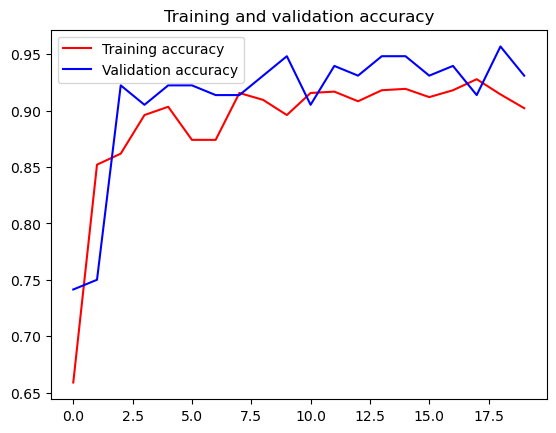

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Test Model

In [38]:
# Define a dictionary to convert label indices to class names
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

# Use the trained model to predict labels for the test images
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,  # Set batch size to 1 to get individual images
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)
predictions = model.predict(test_generator)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [class_names[label] for label in predicted_labels]

# Get the true labels of the test images
true_labels = test_generator.classes
true_labels = [class_names[label] for label in true_labels]

Found 119 images belonging to 2 classes.
119/119 [==============================] - 2s 11ms/step


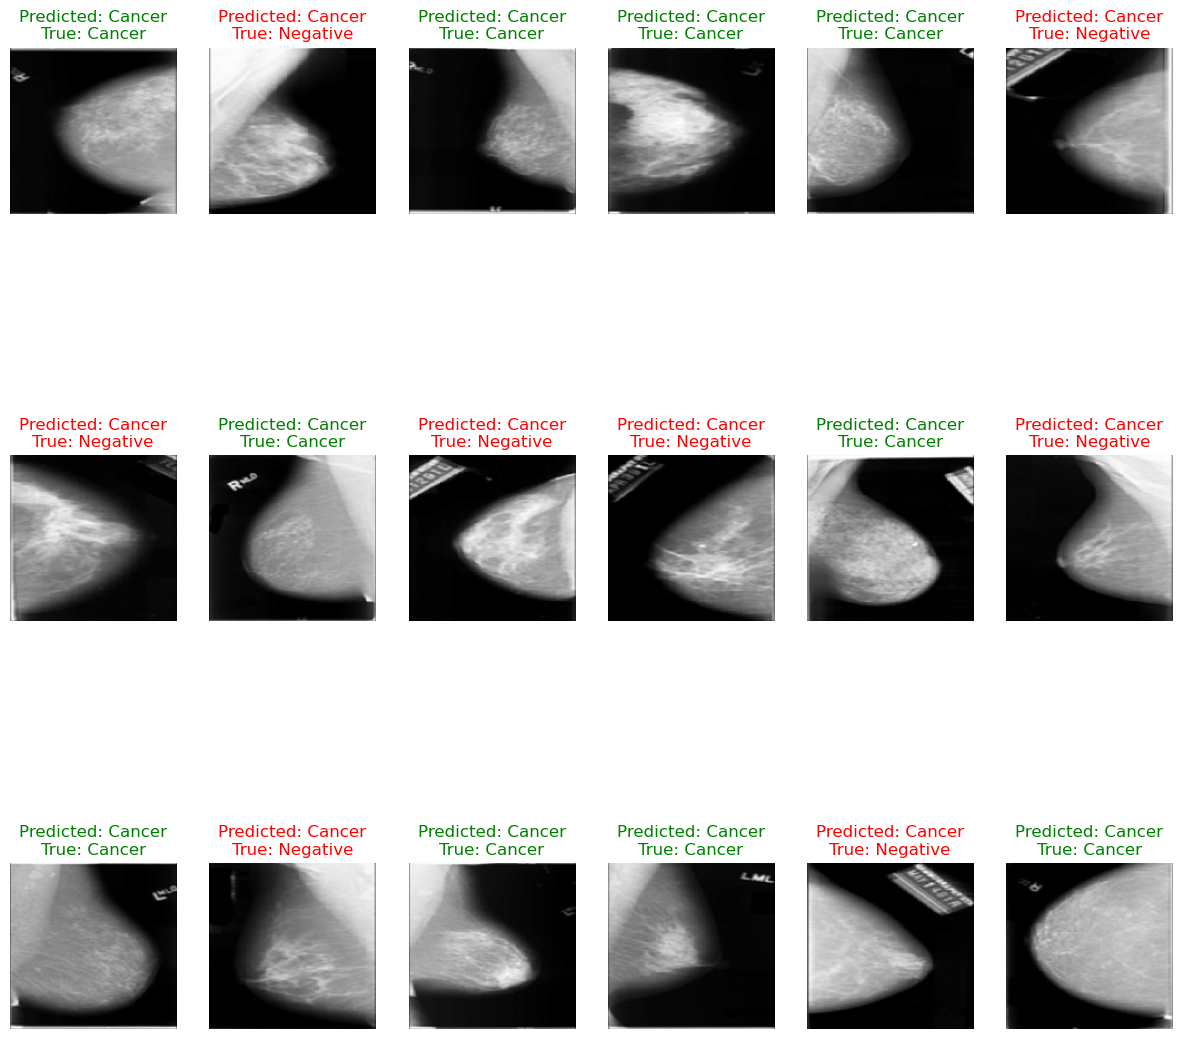

In [50]:
# Print the predicted and true labels for a subset of test images
n_rows = 3
n_cols = 6
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

np.random.seed(42)
random_indexes = np.random.choice(len(predicted_labels), size=n_rows*n_cols, replace=False)

for i, index in enumerate(random_indexes):
    img_path = test_generator.filepaths[index]
    img = image.load_img(img_path, target_size=(150, 150))
    axs[i//n_cols, i%n_cols].imshow(img)
    axs[i//n_cols, i%n_cols].axis('off')
    axs[i//n_cols, i%n_cols].set_title("Predicted: {}\nTrue: {}".format(predicted_labels[index], true_labels[index]), 
                      color='green' if predicted_labels[index] == true_labels[index] else 'red')
plt.show()